## image classification기법 사용

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, he_init_weights
from models.image_classifier import ResNetLike_48_3, ResNetLike_60_3, ResNetLike_108_3, ResNetLike_120_3
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 테스트 지역 선별  
train data와 validaiton data가 인접한 패치가 되면 일반화 성능을 올바르게 검증 할 수 없을 것이다.  
따라서 train data에서 사용한 지역과 어느정도는 떯어진 지역의 패치를 validation data로 이용하도록 한다.  
3000*3000의 정사각형 지역(이미지)를 300*300 크기의 지역 100개로 나눈 후 이중 임의로 약 20개를 뽑아서 validation data로 이용했다.  
아래는 validation data의 위치를 시각화 하는 코드이다.(빨간색이 테스트 지역임)

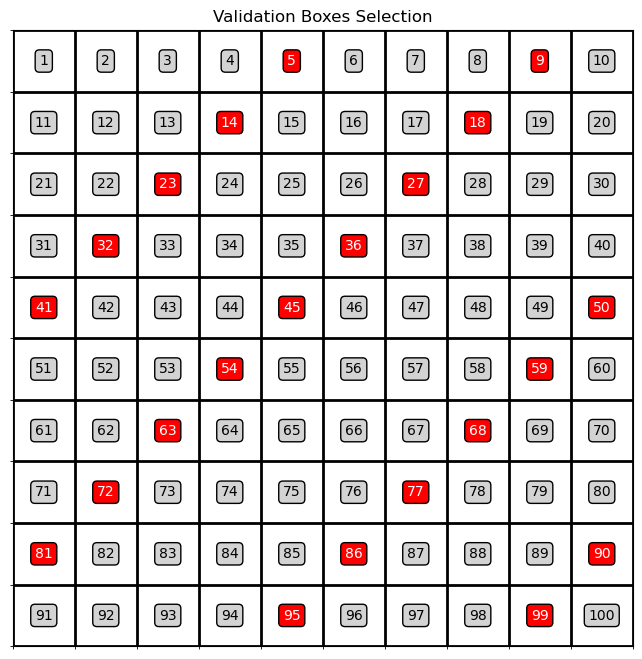

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 10x10 격자에서 1부터 100까지 박스 번호 생성 (책 읽는 순서로)
grid_size = 10
box_numbers = np.arange(1, 101).reshape((grid_size, grid_size), order='C')[::-1]

# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

# 테스트할 박스 선택
test_boxes = np.vectorize(test_filter)(box_numbers)

# 시각화
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 박스에 숫자 표시 및 색상 적용
for i in range(grid_size):
    for j in range(grid_size):
        box_number = box_numbers[i, j]
        ax.text(j, i, str(box_number), ha='center', va='center', fontsize=10, 
                color='white' if test_boxes[i, j] else 'black', 
                bbox=dict(facecolor='red' if test_boxes[i, j] else 'lightgray', 
                          edgecolor='black', boxstyle='round,pad=0.3'))

# 축을 숨김
ax.set_xticks([])
ax.set_yticks([])

plt.title("Validation Boxes Selection")
plt.show()


### 데이터 전처리 방법 - naive

In [4]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

## B, G, R, NIR 데이터만 사용

In [5]:
train_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/naive',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/naive',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.23it/s]



Epoch [1/100], Train Loss: 0.5294, Train Accuracy: 79.91%, Val Loss: 0.7325, Val Accuracy: 77.29%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.33it/s]



Epoch [2/100], Train Loss: 0.4112, Train Accuracy: 84.58%, Val Loss: 0.5123, Val Accuracy: 81.68%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.51it/s]



Epoch [3/100], Train Loss: 0.3636, Train Accuracy: 86.29%, Val Loss: 0.6726, Val Accuracy: 78.33%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.80it/s]



Epoch [4/100], Train Loss: 0.3348, Train Accuracy: 87.47%, Val Loss: 0.6314, Val Accuracy: 81.49%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.30it/s]



Epoch [5/100], Train Loss: 0.3096, Train Accuracy: 88.53%, Val Loss: 0.5478, Val Accuracy: 81.30%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.47it/s]



Epoch [6/100], Train Loss: 0.2914, Train Accuracy: 89.18%, Val Loss: 0.5161, Val Accuracy: 84.89%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.69it/s]



Epoch [7/100], Train Loss: 0.2741, Train Accuracy: 89.78%, Val Loss: 0.6125, Val Accuracy: 81.77%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.48it/s]



Epoch [8/100], Train Loss: 0.2598, Train Accuracy: 90.46%, Val Loss: 0.6757, Val Accuracy: 79.16%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.43it/s]



Epoch [9/100], Train Loss: 0.2467, Train Accuracy: 90.88%, Val Loss: 0.5041, Val Accuracy: 85.19%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.72it/s]



Epoch [10/100], Train Loss: 0.2378, Train Accuracy: 91.27%, Val Loss: 0.7311, Val Accuracy: 80.51%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.98it/s]



Epoch [11/100], Train Loss: 0.2274, Train Accuracy: 91.58%, Val Loss: 0.6289, Val Accuracy: 83.29%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.12it/s]



Epoch [12/100], Train Loss: 0.2191, Train Accuracy: 91.91%, Val Loss: 0.5181, Val Accuracy: 85.30%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.93it/s]



Epoch [13/100], Train Loss: 0.2088, Train Accuracy: 92.27%, Val Loss: 0.6154, Val Accuracy: 83.24%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.53it/s]



Epoch [14/100], Train Loss: 0.2010, Train Accuracy: 92.56%, Val Loss: 0.5743, Val Accuracy: 84.37%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.13it/s]



Epoch [15/100], Train Loss: 0.1953, Train Accuracy: 92.74%, Val Loss: 0.5835, Val Accuracy: 85.26%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.92it/s]



Epoch [16/100], Train Loss: 0.1880, Train Accuracy: 93.14%, Val Loss: 0.6361, Val Accuracy: 84.23%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.08it/s]



Epoch [17/100], Train Loss: 0.1824, Train Accuracy: 93.24%, Val Loss: 0.5802, Val Accuracy: 83.78%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.79it/s]



Epoch [18/100], Train Loss: 0.1750, Train Accuracy: 93.49%, Val Loss: 0.6522, Val Accuracy: 82.30%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.99it/s]



Epoch [19/100], Train Loss: 0.1698, Train Accuracy: 93.76%, Val Loss: 0.7076, Val Accuracy: 81.11%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.20it/s]



Epoch [20/100], Train Loss: 0.1645, Train Accuracy: 93.90%, Val Loss: 0.5646, Val Accuracy: 85.65%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.15it/s]



Epoch [21/100], Train Loss: 0.1618, Train Accuracy: 94.06%, Val Loss: 0.6254, Val Accuracy: 83.72%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.70it/s]



Epoch [22/100], Train Loss: 0.1557, Train Accuracy: 94.25%, Val Loss: 0.6378, Val Accuracy: 83.55%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.30it/s]



Epoch [23/100], Train Loss: 0.1520, Train Accuracy: 94.35%, Val Loss: 0.6065, Val Accuracy: 83.79%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.39it/s]



Epoch [24/100], Train Loss: 0.1471, Train Accuracy: 94.47%, Val Loss: 0.7037, Val Accuracy: 82.09%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.87it/s]



Epoch [25/100], Train Loss: 0.1428, Train Accuracy: 94.71%, Val Loss: 0.6684, Val Accuracy: 84.16%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.68it/s]



Epoch [26/100], Train Loss: 0.1395, Train Accuracy: 94.77%, Val Loss: 0.6762, Val Accuracy: 82.87%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.58it/s]



Epoch [27/100], Train Loss: 0.1345, Train Accuracy: 94.99%, Val Loss: 0.6200, Val Accuracy: 84.98%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.25it/s]



Epoch [28/100], Train Loss: 0.1299, Train Accuracy: 95.13%, Val Loss: 0.6163, Val Accuracy: 84.75%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.33it/s]



Epoch [29/100], Train Loss: 0.1268, Train Accuracy: 95.25%, Val Loss: 0.6397, Val Accuracy: 84.28%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.06it/s]



Epoch [30/100], Train Loss: 0.1236, Train Accuracy: 95.40%, Val Loss: 0.6441, Val Accuracy: 85.28%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.29it/s]



Epoch [31/100], Train Loss: 0.1202, Train Accuracy: 95.55%, Val Loss: 0.7244, Val Accuracy: 83.77%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.27it/s]



Epoch [32/100], Train Loss: 0.1178, Train Accuracy: 95.58%, Val Loss: 0.7709, Val Accuracy: 83.60%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.88it/s]



Epoch [33/100], Train Loss: 0.1138, Train Accuracy: 95.73%, Val Loss: 0.7707, Val Accuracy: 83.01%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.29it/s]



Epoch [34/100], Train Loss: 0.1104, Train Accuracy: 95.89%, Val Loss: 0.7853, Val Accuracy: 83.12%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:08<00:00, 143.55it/s]



Epoch [35/100], Train Loss: 0.1093, Train Accuracy: 95.85%, Val Loss: 0.7013, Val Accuracy: 85.34%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.18it/s]



Epoch [36/100], Train Loss: 0.1058, Train Accuracy: 96.01%, Val Loss: 0.7947, Val Accuracy: 83.62%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.00it/s]



Epoch [37/100], Train Loss: 0.1021, Train Accuracy: 96.16%, Val Loss: 0.7735, Val Accuracy: 84.36%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.36it/s]



Epoch [38/100], Train Loss: 0.0994, Train Accuracy: 96.23%, Val Loss: 0.7368, Val Accuracy: 84.19%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.57it/s]



Epoch [39/100], Train Loss: 0.0985, Train Accuracy: 96.29%, Val Loss: 0.8103, Val Accuracy: 84.44%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.44it/s]



Epoch [40/100], Train Loss: 0.0938, Train Accuracy: 96.45%, Val Loss: 0.8597, Val Accuracy: 81.05%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.40it/s]



Epoch [41/100], Train Loss: 0.0917, Train Accuracy: 96.59%, Val Loss: 0.7043, Val Accuracy: 84.41%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 193.43it/s]



Epoch [42/100], Train Loss: 0.0892, Train Accuracy: 96.63%, Val Loss: 0.9365, Val Accuracy: 82.74%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.91it/s]



Epoch [43/100], Train Loss: 0.0889, Train Accuracy: 96.67%, Val Loss: 0.8419, Val Accuracy: 82.88%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:08<00:00, 131.52it/s]



Epoch [44/100], Train Loss: 0.0856, Train Accuracy: 96.77%, Val Loss: 0.7729, Val Accuracy: 83.19%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 83.32it/s]



Epoch [45/100], Train Loss: 0.0840, Train Accuracy: 96.84%, Val Loss: 0.7462, Val Accuracy: 84.78%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 85.04it/s]



Epoch [46/100], Train Loss: 0.0827, Train Accuracy: 96.93%, Val Loss: 0.8815, Val Accuracy: 82.94%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.21it/s]



Epoch [47/100], Train Loss: 0.0793, Train Accuracy: 97.00%, Val Loss: 0.8407, Val Accuracy: 83.46%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.57it/s]



Epoch [48/100], Train Loss: 0.0781, Train Accuracy: 97.07%, Val Loss: 0.9538, Val Accuracy: 83.10%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:08<00:00, 137.28it/s]



Epoch [49/100], Train Loss: 0.0762, Train Accuracy: 97.11%, Val Loss: 0.8435, Val Accuracy: 84.72%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.68it/s]



Epoch [50/100], Train Loss: 0.0744, Train Accuracy: 97.21%, Val Loss: 0.8361, Val Accuracy: 84.16%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.02it/s]



Epoch [51/100], Train Loss: 0.0722, Train Accuracy: 97.29%, Val Loss: 0.8949, Val Accuracy: 83.47%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.73it/s]



Epoch [52/100], Train Loss: 0.0710, Train Accuracy: 97.32%, Val Loss: 0.8342, Val Accuracy: 84.26%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:07<00:00, 162.52it/s]



Epoch [53/100], Train Loss: 0.0696, Train Accuracy: 97.40%, Val Loss: 0.8175, Val Accuracy: 83.79%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.83it/s]



Epoch [54/100], Train Loss: 0.0689, Train Accuracy: 97.38%, Val Loss: 0.9777, Val Accuracy: 82.87%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.89it/s]



Epoch [55/100], Train Loss: 0.0662, Train Accuracy: 97.49%, Val Loss: 0.8217, Val Accuracy: 83.82%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.56it/s]



Epoch [56/100], Train Loss: 0.0657, Train Accuracy: 97.54%, Val Loss: 0.8478, Val Accuracy: 83.57%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.89it/s]



Epoch [57/100], Train Loss: 0.0645, Train Accuracy: 97.61%, Val Loss: 0.8639, Val Accuracy: 84.25%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.30it/s]



Epoch [58/100], Train Loss: 0.0625, Train Accuracy: 97.65%, Val Loss: 0.8695, Val Accuracy: 84.41%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.20it/s]



Epoch [59/100], Train Loss: 0.0606, Train Accuracy: 97.78%, Val Loss: 0.9828, Val Accuracy: 82.28%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.69it/s]



Epoch [60/100], Train Loss: 0.0619, Train Accuracy: 97.71%, Val Loss: 0.8773, Val Accuracy: 83.68%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.79it/s]



Epoch [61/100], Train Loss: 0.0592, Train Accuracy: 97.79%, Val Loss: 0.9131, Val Accuracy: 83.45%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.97it/s]



Epoch [62/100], Train Loss: 0.0583, Train Accuracy: 97.81%, Val Loss: 1.0217, Val Accuracy: 81.72%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.36it/s]



Epoch [63/100], Train Loss: 0.0570, Train Accuracy: 97.85%, Val Loss: 0.9189, Val Accuracy: 85.24%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.03it/s]



Epoch [64/100], Train Loss: 0.0563, Train Accuracy: 97.88%, Val Loss: 0.8536, Val Accuracy: 83.84%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.53it/s]



Epoch [65/100], Train Loss: 0.0531, Train Accuracy: 98.01%, Val Loss: 0.8679, Val Accuracy: 84.85%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.53it/s]



Epoch [66/100], Train Loss: 0.0533, Train Accuracy: 98.03%, Val Loss: 0.8517, Val Accuracy: 84.11%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.43it/s]



Epoch [67/100], Train Loss: 0.0531, Train Accuracy: 98.04%, Val Loss: 1.0141, Val Accuracy: 83.61%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.61it/s]



Epoch [68/100], Train Loss: 0.0531, Train Accuracy: 98.02%, Val Loss: 0.9117, Val Accuracy: 84.31%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.20it/s]



Epoch [69/100], Train Loss: 0.0504, Train Accuracy: 98.14%, Val Loss: 0.8330, Val Accuracy: 84.87%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.51it/s]



Epoch [70/100], Train Loss: 0.0495, Train Accuracy: 98.15%, Val Loss: 0.9208, Val Accuracy: 84.33%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.92it/s]



Epoch [71/100], Train Loss: 0.0495, Train Accuracy: 98.15%, Val Loss: 0.8650, Val Accuracy: 85.24%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.57it/s]



Epoch [72/100], Train Loss: 0.0499, Train Accuracy: 98.15%, Val Loss: 0.9579, Val Accuracy: 84.43%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.11it/s]



Epoch [73/100], Train Loss: 0.0474, Train Accuracy: 98.22%, Val Loss: 1.0567, Val Accuracy: 82.63%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.97it/s]



Epoch [74/100], Train Loss: 0.0453, Train Accuracy: 98.32%, Val Loss: 0.8473, Val Accuracy: 85.22%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.93it/s]



Epoch [75/100], Train Loss: 0.0478, Train Accuracy: 98.23%, Val Loss: 0.9046, Val Accuracy: 83.83%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.90it/s]



Epoch [76/100], Train Loss: 0.0446, Train Accuracy: 98.38%, Val Loss: 0.9064, Val Accuracy: 83.96%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.28it/s]



Epoch [77/100], Train Loss: 0.0470, Train Accuracy: 98.26%, Val Loss: 1.0016, Val Accuracy: 83.28%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.51it/s]



Epoch [78/100], Train Loss: 0.0441, Train Accuracy: 98.37%, Val Loss: 0.9726, Val Accuracy: 85.41%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.19it/s]



Epoch [79/100], Train Loss: 0.0436, Train Accuracy: 98.39%, Val Loss: 1.0279, Val Accuracy: 83.91%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.65it/s]



Epoch [80/100], Train Loss: 0.0411, Train Accuracy: 98.50%, Val Loss: 1.0465, Val Accuracy: 84.03%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.65it/s]



Epoch [81/100], Train Loss: 0.0426, Train Accuracy: 98.44%, Val Loss: 0.9587, Val Accuracy: 83.76%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.78it/s]



Epoch [82/100], Train Loss: 0.0422, Train Accuracy: 98.48%, Val Loss: 0.9715, Val Accuracy: 84.66%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.38it/s]



Epoch [83/100], Train Loss: 0.0416, Train Accuracy: 98.44%, Val Loss: 1.0967, Val Accuracy: 82.76%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.02it/s]



Epoch [84/100], Train Loss: 0.0401, Train Accuracy: 98.52%, Val Loss: 0.9342, Val Accuracy: 84.76%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.79it/s]



Epoch [85/100], Train Loss: 0.0397, Train Accuracy: 98.52%, Val Loss: 0.8588, Val Accuracy: 84.06%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.63it/s]



Epoch [86/100], Train Loss: 0.0381, Train Accuracy: 98.63%, Val Loss: 0.8921, Val Accuracy: 84.83%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.48it/s]



Epoch [87/100], Train Loss: 0.0392, Train Accuracy: 98.56%, Val Loss: 1.1163, Val Accuracy: 82.91%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.02it/s]



Epoch [88/100], Train Loss: 0.0385, Train Accuracy: 98.61%, Val Loss: 1.0617, Val Accuracy: 83.88%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.77it/s]



Epoch [89/100], Train Loss: 0.0378, Train Accuracy: 98.61%, Val Loss: 0.9729, Val Accuracy: 84.54%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.93it/s]



Epoch [90/100], Train Loss: 0.0383, Train Accuracy: 98.59%, Val Loss: 1.0166, Val Accuracy: 83.86%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.75it/s]



Epoch [91/100], Train Loss: 0.0361, Train Accuracy: 98.65%, Val Loss: 1.1430, Val Accuracy: 83.12%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.47it/s]



Epoch [92/100], Train Loss: 0.0373, Train Accuracy: 98.65%, Val Loss: 1.1601, Val Accuracy: 83.80%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.16it/s]



Epoch [93/100], Train Loss: 0.0345, Train Accuracy: 98.76%, Val Loss: 1.1508, Val Accuracy: 83.71%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.86it/s]



Epoch [94/100], Train Loss: 0.0367, Train Accuracy: 98.67%, Val Loss: 1.0553, Val Accuracy: 84.23%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.86it/s]



Epoch [95/100], Train Loss: 0.0340, Train Accuracy: 98.75%, Val Loss: 1.0555, Val Accuracy: 84.02%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.74it/s]



Epoch [96/100], Train Loss: 0.0352, Train Accuracy: 98.75%, Val Loss: 1.1422, Val Accuracy: 84.39%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.61it/s]



Epoch [97/100], Train Loss: 0.0338, Train Accuracy: 98.78%, Val Loss: 1.0791, Val Accuracy: 82.94%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.25it/s]



Epoch [98/100], Train Loss: 0.0338, Train Accuracy: 98.77%, Val Loss: 1.0371, Val Accuracy: 84.10%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 89.05it/s]



Epoch [99/100], Train Loss: 0.0342, Train Accuracy: 98.77%, Val Loss: 1.2046, Val Accuracy: 82.32%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:13<00:00, 88.97it/s]



Epoch [100/100], Train Loss: 0.0328, Train Accuracy: 98.81%, Val Loss: 1.1806, Val Accuracy: 83.62%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:38<00:00, 94.90it/s] 


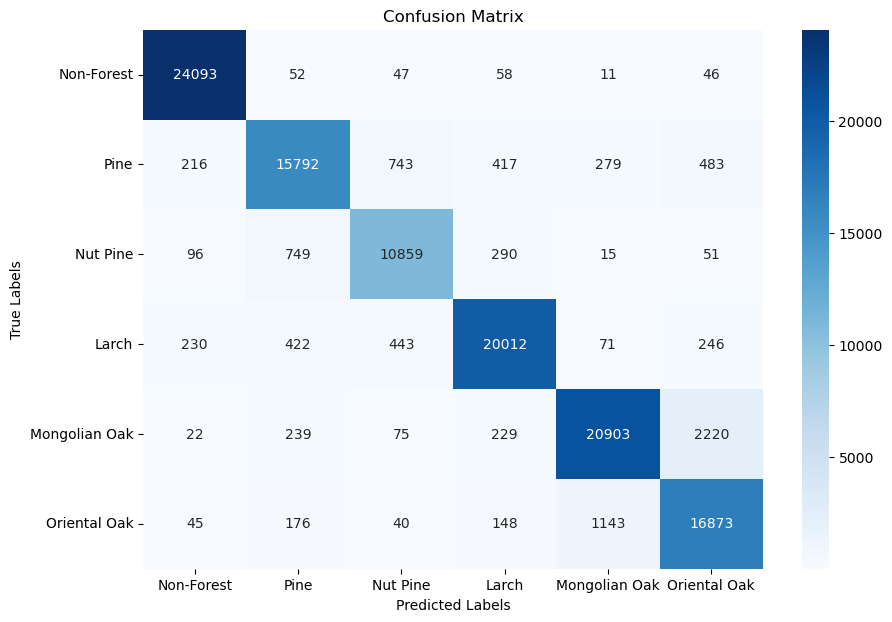

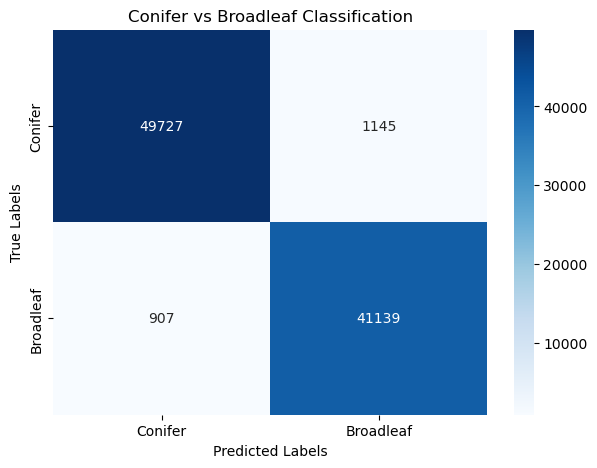

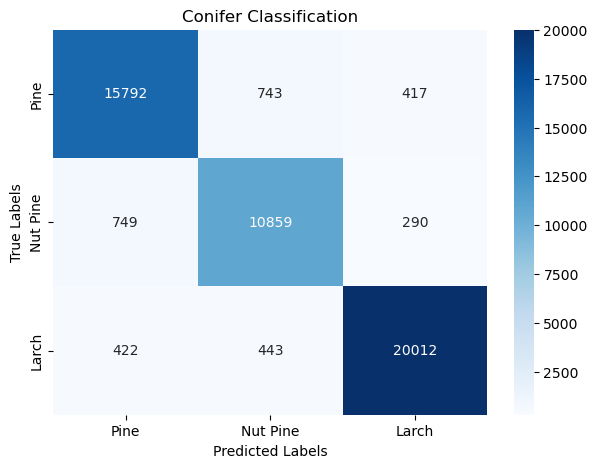

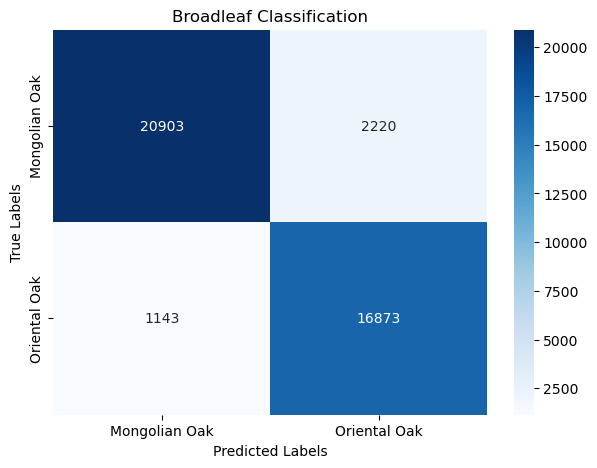


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:11<00:00, 98.47it/s]


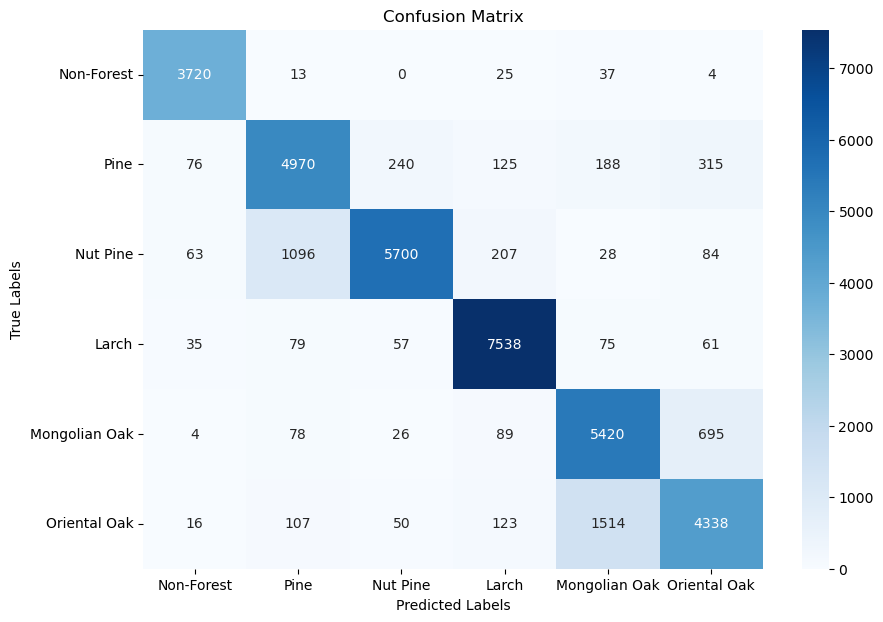

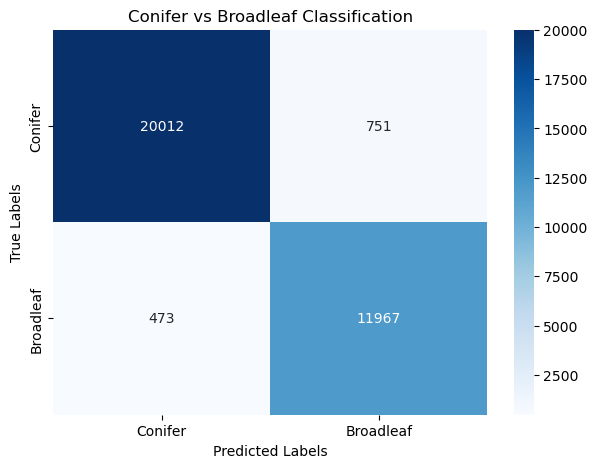

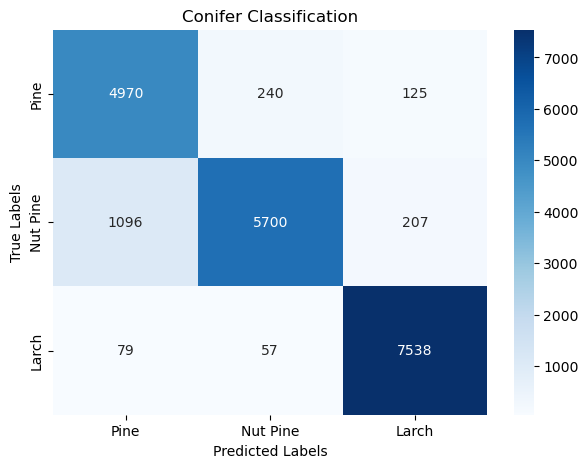

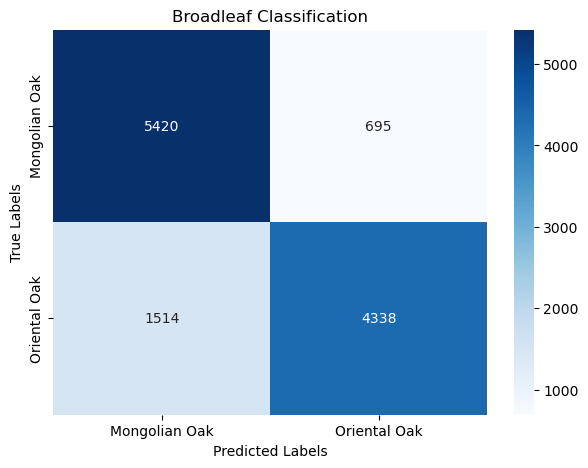

,precision,recall,f1-score,support,Category
Non-Forest,0.950434,0.979205,0.964605,3799.000000,Overall
Pine,0.783541,0.840379,0.810965,5914.000000,Overall
Nut Pine,0.938581,0.794093,0.860312,7178.000000,Overall
Larch,0.929814,0.960867,0.945085,7845.000000,Overall
Mongolian Oak,0.746351,0.858682,0.798586,6312.000000,Overall
Oriental Oak,0.789158,0.705595,0.745041,6148.000000,Overall
accuracy,0.851866,0.851866,0.851866,0.851866,Overall
macro avg,0.856313,0.856470,0.854099,37196.000000,Overall
weighted avg,0.855973,0.851866,0.851470,37196.000000,Overall
Conifer,0.976910,0.963830,0.970326,20763.000000,Conifer vs Broadleaf


In [6]:
model = ResNetLike_48_3(num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
os.makedirs("./checkpoints/image_classification",exist_ok=True)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_48_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI도 추가된 데이터 사용

In [7]:
train_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/with_ndvi',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/with_ndvi',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.47it/s]



Epoch [1/100], Train Loss: 0.5692, Train Accuracy: 78.13%, Val Loss: 1.0099, Val Accuracy: 64.52%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.60it/s]



Epoch [2/100], Train Loss: 0.4600, Train Accuracy: 82.83%, Val Loss: 0.6112, Val Accuracy: 78.79%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.51it/s]



Epoch [3/100], Train Loss: 0.4237, Train Accuracy: 84.15%, Val Loss: 0.5441, Val Accuracy: 80.91%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.17it/s]



Epoch [4/100], Train Loss: 0.3957, Train Accuracy: 85.15%, Val Loss: 0.7382, Val Accuracy: 73.64%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.28it/s]



Epoch [5/100], Train Loss: 0.3751, Train Accuracy: 85.93%, Val Loss: 0.5660, Val Accuracy: 82.23%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.09it/s]



Epoch [6/100], Train Loss: 0.3563, Train Accuracy: 86.51%, Val Loss: 0.6148, Val Accuracy: 79.80%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.36it/s]



Epoch [7/100], Train Loss: 0.3408, Train Accuracy: 87.16%, Val Loss: 0.5894, Val Accuracy: 80.62%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.20it/s]



Epoch [8/100], Train Loss: 0.3268, Train Accuracy: 87.62%, Val Loss: 1.0687, Val Accuracy: 70.73%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.75it/s] 



Epoch [9/100], Train Loss: 0.3151, Train Accuracy: 88.01%, Val Loss: 0.6308, Val Accuracy: 79.75%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.31it/s]



Epoch [10/100], Train Loss: 0.3035, Train Accuracy: 88.56%, Val Loss: 0.6621, Val Accuracy: 79.43%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.36it/s]



Epoch [11/100], Train Loss: 0.2925, Train Accuracy: 89.01%, Val Loss: 0.5612, Val Accuracy: 83.57%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.87it/s]



Epoch [12/100], Train Loss: 0.2841, Train Accuracy: 89.37%, Val Loss: 0.5073, Val Accuracy: 83.63%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.08it/s]



Epoch [13/100], Train Loss: 0.2708, Train Accuracy: 89.90%, Val Loss: 0.6302, Val Accuracy: 81.85%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.90it/s]



Epoch [14/100], Train Loss: 0.2653, Train Accuracy: 90.05%, Val Loss: 0.5555, Val Accuracy: 81.16%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.27it/s]



Epoch [15/100], Train Loss: 0.2557, Train Accuracy: 90.45%, Val Loss: 0.6129, Val Accuracy: 80.55%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.40it/s]



Epoch [16/100], Train Loss: 0.2475, Train Accuracy: 90.76%, Val Loss: 0.6003, Val Accuracy: 81.10%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.59it/s]



Epoch [17/100], Train Loss: 0.2412, Train Accuracy: 91.06%, Val Loss: 0.8299, Val Accuracy: 75.19%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.61it/s]



Epoch [18/100], Train Loss: 0.2343, Train Accuracy: 91.28%, Val Loss: 0.5505, Val Accuracy: 84.47%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.00it/s]



Epoch [19/100], Train Loss: 0.2271, Train Accuracy: 91.53%, Val Loss: 0.6464, Val Accuracy: 81.98%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.27it/s]



Epoch [20/100], Train Loss: 0.2176, Train Accuracy: 91.91%, Val Loss: 0.7304, Val Accuracy: 80.34%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.45it/s] 



Epoch [21/100], Train Loss: 0.2129, Train Accuracy: 92.06%, Val Loss: 0.7077, Val Accuracy: 81.22%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.80it/s]



Epoch [22/100], Train Loss: 0.2066, Train Accuracy: 92.27%, Val Loss: 0.6454, Val Accuracy: 82.54%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.21it/s]



Epoch [23/100], Train Loss: 0.2026, Train Accuracy: 92.43%, Val Loss: 0.6270, Val Accuracy: 82.42%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.38it/s]



Epoch [24/100], Train Loss: 0.1965, Train Accuracy: 92.67%, Val Loss: 0.6873, Val Accuracy: 82.53%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.30it/s]



Epoch [25/100], Train Loss: 0.1910, Train Accuracy: 92.97%, Val Loss: 0.8675, Val Accuracy: 77.70%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 98.67it/s] 



Epoch [26/100], Train Loss: 0.1843, Train Accuracy: 93.11%, Val Loss: 0.7577, Val Accuracy: 82.21%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.09it/s]



Epoch [27/100], Train Loss: 0.1799, Train Accuracy: 93.33%, Val Loss: 0.6220, Val Accuracy: 83.26%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.18it/s]



Epoch [28/100], Train Loss: 0.1770, Train Accuracy: 93.46%, Val Loss: 0.6975, Val Accuracy: 81.43%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.55it/s]



Epoch [29/100], Train Loss: 0.1717, Train Accuracy: 93.59%, Val Loss: 0.7944, Val Accuracy: 77.24%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.66it/s]



Epoch [30/100], Train Loss: 0.1669, Train Accuracy: 93.80%, Val Loss: 0.7025, Val Accuracy: 82.07%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.25it/s]



Epoch [31/100], Train Loss: 0.1634, Train Accuracy: 93.90%, Val Loss: 0.5806, Val Accuracy: 83.66%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.27it/s]



Epoch [32/100], Train Loss: 0.1594, Train Accuracy: 94.04%, Val Loss: 0.7928, Val Accuracy: 80.69%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.56it/s]



Epoch [33/100], Train Loss: 0.1550, Train Accuracy: 94.22%, Val Loss: 0.8172, Val Accuracy: 80.19%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.14it/s]



Epoch [34/100], Train Loss: 0.1510, Train Accuracy: 94.36%, Val Loss: 0.8777, Val Accuracy: 78.29%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.65it/s]



Epoch [35/100], Train Loss: 0.1478, Train Accuracy: 94.47%, Val Loss: 0.7439, Val Accuracy: 83.08%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.73it/s]



Epoch [36/100], Train Loss: 0.1424, Train Accuracy: 94.64%, Val Loss: 0.7064, Val Accuracy: 82.80%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.94it/s]



Epoch [37/100], Train Loss: 0.1399, Train Accuracy: 94.81%, Val Loss: 0.7499, Val Accuracy: 83.44%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 96.16it/s] 



Epoch [38/100], Train Loss: 0.1391, Train Accuracy: 94.78%, Val Loss: 0.7377, Val Accuracy: 83.20%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.91it/s]



Epoch [39/100], Train Loss: 0.1335, Train Accuracy: 95.05%, Val Loss: 0.8634, Val Accuracy: 80.16%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.70it/s]



Epoch [40/100], Train Loss: 0.1305, Train Accuracy: 95.05%, Val Loss: 0.7588, Val Accuracy: 83.12%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.62it/s]



Epoch [41/100], Train Loss: 0.1299, Train Accuracy: 95.19%, Val Loss: 0.7009, Val Accuracy: 82.35%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.58it/s]



Epoch [42/100], Train Loss: 0.1238, Train Accuracy: 95.33%, Val Loss: 0.6816, Val Accuracy: 84.17%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.38it/s]



Epoch [43/100], Train Loss: 0.1229, Train Accuracy: 95.42%, Val Loss: 0.7187, Val Accuracy: 83.13%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.32it/s]



Epoch [44/100], Train Loss: 0.1185, Train Accuracy: 95.51%, Val Loss: 0.7296, Val Accuracy: 83.15%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.52it/s]



Epoch [45/100], Train Loss: 0.1161, Train Accuracy: 95.62%, Val Loss: 0.8210, Val Accuracy: 81.93%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.77it/s]



Epoch [46/100], Train Loss: 0.1130, Train Accuracy: 95.79%, Val Loss: 0.7497, Val Accuracy: 82.66%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.97it/s]



Epoch [47/100], Train Loss: 0.1117, Train Accuracy: 95.79%, Val Loss: 0.7027, Val Accuracy: 83.75%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.06it/s]



Epoch [48/100], Train Loss: 0.1083, Train Accuracy: 95.93%, Val Loss: 0.8960, Val Accuracy: 80.47%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.06it/s]



Epoch [49/100], Train Loss: 0.1072, Train Accuracy: 95.99%, Val Loss: 0.8251, Val Accuracy: 80.28%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.18it/s] 



Epoch [50/100], Train Loss: 0.1028, Train Accuracy: 96.15%, Val Loss: 0.7918, Val Accuracy: 82.00%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.44it/s]



Epoch [51/100], Train Loss: 0.1016, Train Accuracy: 96.16%, Val Loss: 0.9122, Val Accuracy: 82.46%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.79it/s]



Epoch [52/100], Train Loss: 0.1006, Train Accuracy: 96.20%, Val Loss: 0.8050, Val Accuracy: 84.56%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.91it/s]



Epoch [53/100], Train Loss: 0.0965, Train Accuracy: 96.41%, Val Loss: 0.8265, Val Accuracy: 82.62%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.26it/s]



Epoch [54/100], Train Loss: 0.0938, Train Accuracy: 96.48%, Val Loss: 1.0516, Val Accuracy: 82.01%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 98.17it/s] 



Epoch [55/100], Train Loss: 0.0926, Train Accuracy: 96.52%, Val Loss: 0.7631, Val Accuracy: 83.63%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.43it/s]



Epoch [56/100], Train Loss: 0.0904, Train Accuracy: 96.61%, Val Loss: 0.7836, Val Accuracy: 84.05%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.33it/s]



Epoch [57/100], Train Loss: 0.0879, Train Accuracy: 96.71%, Val Loss: 0.9598, Val Accuracy: 82.29%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.88it/s]



Epoch [58/100], Train Loss: 0.0872, Train Accuracy: 96.73%, Val Loss: 0.9239, Val Accuracy: 83.10%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.13it/s]



Epoch [59/100], Train Loss: 0.0845, Train Accuracy: 96.82%, Val Loss: 0.8866, Val Accuracy: 82.68%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.77it/s]



Epoch [60/100], Train Loss: 0.0831, Train Accuracy: 96.86%, Val Loss: 1.0895, Val Accuracy: 81.39%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.38it/s]



Epoch [61/100], Train Loss: 0.0813, Train Accuracy: 96.99%, Val Loss: 1.1093, Val Accuracy: 79.73%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.93it/s]



Epoch [62/100], Train Loss: 0.0791, Train Accuracy: 97.04%, Val Loss: 0.8517, Val Accuracy: 83.44%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.36it/s]



Epoch [63/100], Train Loss: 0.0769, Train Accuracy: 97.14%, Val Loss: 1.2046, Val Accuracy: 81.72%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.36it/s]



Epoch [64/100], Train Loss: 0.0777, Train Accuracy: 97.10%, Val Loss: 1.0659, Val Accuracy: 82.47%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.86it/s]



Epoch [65/100], Train Loss: 0.0754, Train Accuracy: 97.18%, Val Loss: 1.0550, Val Accuracy: 82.24%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.62it/s]



Epoch [66/100], Train Loss: 0.0747, Train Accuracy: 97.22%, Val Loss: 0.9677, Val Accuracy: 83.03%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.39it/s] 



Epoch [67/100], Train Loss: 0.0723, Train Accuracy: 97.29%, Val Loss: 1.0274, Val Accuracy: 81.97%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.04it/s]



Epoch [68/100], Train Loss: 0.0718, Train Accuracy: 97.32%, Val Loss: 1.0771, Val Accuracy: 80.80%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.43it/s]



Epoch [69/100], Train Loss: 0.0676, Train Accuracy: 97.49%, Val Loss: 0.8858, Val Accuracy: 83.72%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 89.76it/s]



Epoch [70/100], Train Loss: 0.0685, Train Accuracy: 97.45%, Val Loss: 1.0658, Val Accuracy: 81.83%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.98it/s]



Epoch [71/100], Train Loss: 0.0691, Train Accuracy: 97.43%, Val Loss: 0.9061, Val Accuracy: 84.13%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.76it/s]



Epoch [72/100], Train Loss: 0.0659, Train Accuracy: 97.52%, Val Loss: 1.1991, Val Accuracy: 81.29%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.49it/s]



Epoch [73/100], Train Loss: 0.0650, Train Accuracy: 97.58%, Val Loss: 1.1704, Val Accuracy: 82.57%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.25it/s]



Epoch [74/100], Train Loss: 0.0622, Train Accuracy: 97.68%, Val Loss: 0.9705, Val Accuracy: 81.40%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.50it/s]



Epoch [75/100], Train Loss: 0.0638, Train Accuracy: 97.61%, Val Loss: 0.9430, Val Accuracy: 83.51%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.87it/s]



Epoch [76/100], Train Loss: 0.0615, Train Accuracy: 97.72%, Val Loss: 1.0703, Val Accuracy: 82.76%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.13it/s]



Epoch [77/100], Train Loss: 0.0583, Train Accuracy: 97.84%, Val Loss: 1.0537, Val Accuracy: 82.50%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.00it/s]



Epoch [78/100], Train Loss: 0.0586, Train Accuracy: 97.79%, Val Loss: 1.0976, Val Accuracy: 83.47%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.08it/s] 



Epoch [79/100], Train Loss: 0.0582, Train Accuracy: 97.85%, Val Loss: 1.1549, Val Accuracy: 82.56%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.79it/s]



Epoch [80/100], Train Loss: 0.0571, Train Accuracy: 97.92%, Val Loss: 0.9853, Val Accuracy: 80.73%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.26it/s]



Epoch [81/100], Train Loss: 0.0552, Train Accuracy: 97.95%, Val Loss: 1.0870, Val Accuracy: 82.33%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.41it/s]



Epoch [82/100], Train Loss: 0.0557, Train Accuracy: 97.94%, Val Loss: 1.1969, Val Accuracy: 81.15%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.05it/s]



Epoch [83/100], Train Loss: 0.0533, Train Accuracy: 98.05%, Val Loss: 1.1875, Val Accuracy: 82.79%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.58it/s]



Epoch [84/100], Train Loss: 0.0523, Train Accuracy: 98.06%, Val Loss: 1.0615, Val Accuracy: 83.76%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.92it/s]



Epoch [85/100], Train Loss: 0.0514, Train Accuracy: 98.08%, Val Loss: 1.3340, Val Accuracy: 79.23%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.19it/s]



Epoch [86/100], Train Loss: 0.0525, Train Accuracy: 98.06%, Val Loss: 1.1171, Val Accuracy: 82.39%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.73it/s]



Epoch [87/100], Train Loss: 0.0524, Train Accuracy: 98.09%, Val Loss: 1.0212, Val Accuracy: 82.43%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.59it/s]



Epoch [88/100], Train Loss: 0.0499, Train Accuracy: 98.16%, Val Loss: 1.1835, Val Accuracy: 81.16%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.17it/s]



Epoch [89/100], Train Loss: 0.0491, Train Accuracy: 98.23%, Val Loss: 1.1646, Val Accuracy: 81.52%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.75it/s]



Epoch [90/100], Train Loss: 0.0487, Train Accuracy: 98.24%, Val Loss: 1.6154, Val Accuracy: 76.93%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 95.33it/s] 



Epoch [91/100], Train Loss: 0.0483, Train Accuracy: 98.25%, Val Loss: 1.0587, Val Accuracy: 83.09%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 90.73it/s]



Epoch [92/100], Train Loss: 0.0464, Train Accuracy: 98.28%, Val Loss: 1.2106, Val Accuracy: 82.87%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.09it/s]



Epoch [93/100], Train Loss: 0.0473, Train Accuracy: 98.26%, Val Loss: 1.2458, Val Accuracy: 80.37%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.04it/s]



Epoch [94/100], Train Loss: 0.0455, Train Accuracy: 98.34%, Val Loss: 2.1498, Val Accuracy: 80.62%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.81it/s]



Epoch [95/100], Train Loss: 0.0447, Train Accuracy: 98.37%, Val Loss: 1.0246, Val Accuracy: 83.64%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 97.08it/s]



Epoch [96/100], Train Loss: 0.0434, Train Accuracy: 98.41%, Val Loss: 1.7264, Val Accuracy: 81.80%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.42it/s]



Epoch [97/100], Train Loss: 0.0430, Train Accuracy: 98.42%, Val Loss: 1.6926, Val Accuracy: 82.50%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.31it/s]



Epoch [98/100], Train Loss: 0.0432, Train Accuracy: 98.46%, Val Loss: 1.4057, Val Accuracy: 82.27%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.13it/s]



Epoch [99/100], Train Loss: 0.0418, Train Accuracy: 98.46%, Val Loss: 1.0996, Val Accuracy: 83.16%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 91.35it/s]



Epoch [100/100], Train Loss: 0.0429, Train Accuracy: 98.44%, Val Loss: 1.2759, Val Accuracy: 80.98%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:37<00:00, 97.42it/s] 


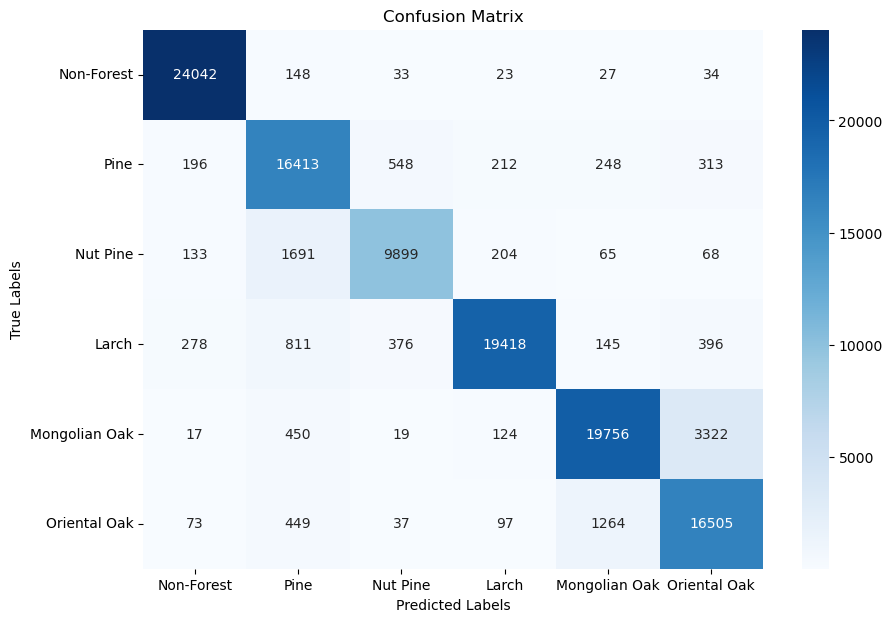

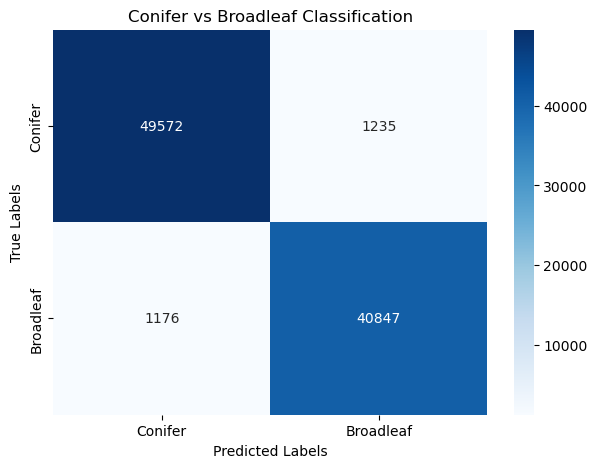

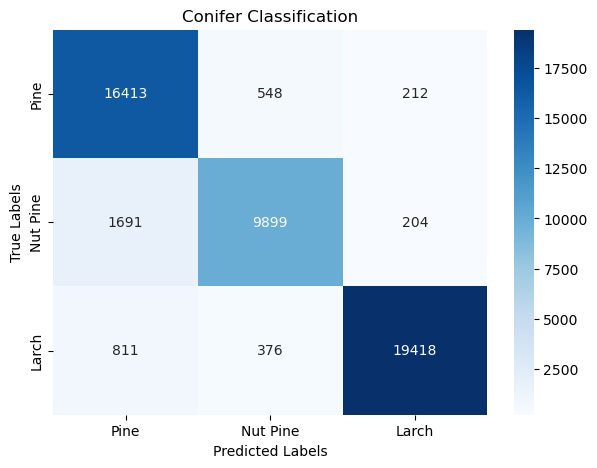

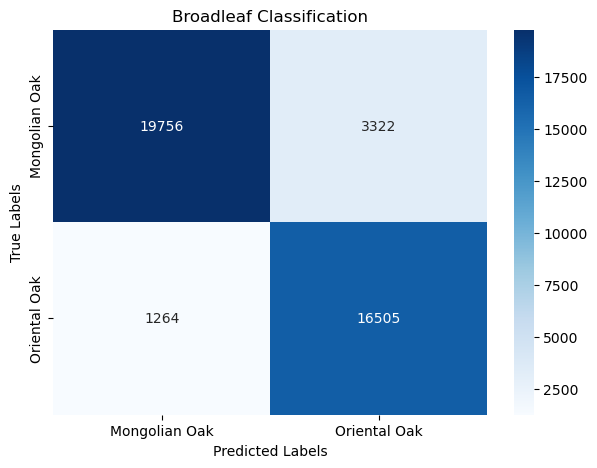


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:11<00:00, 100.63it/s]


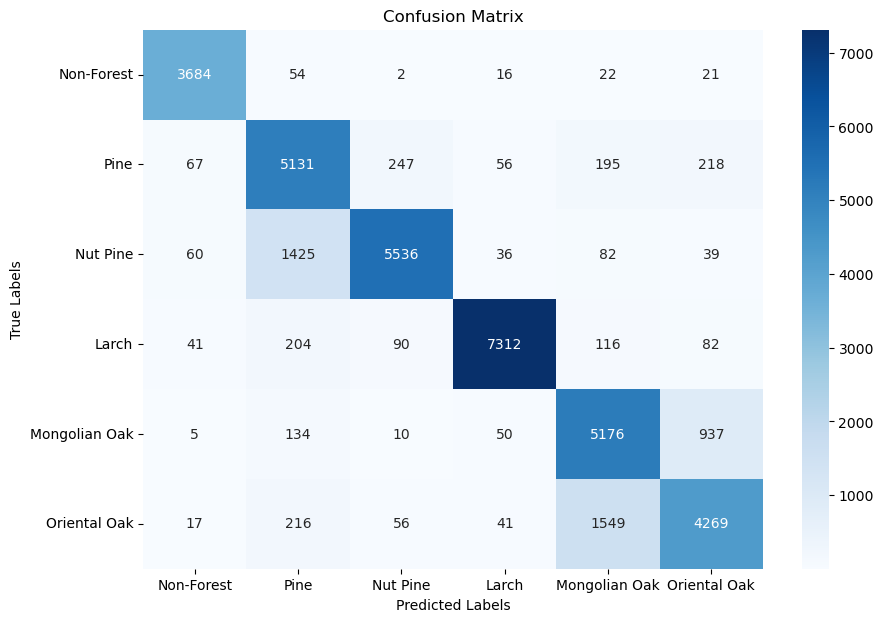

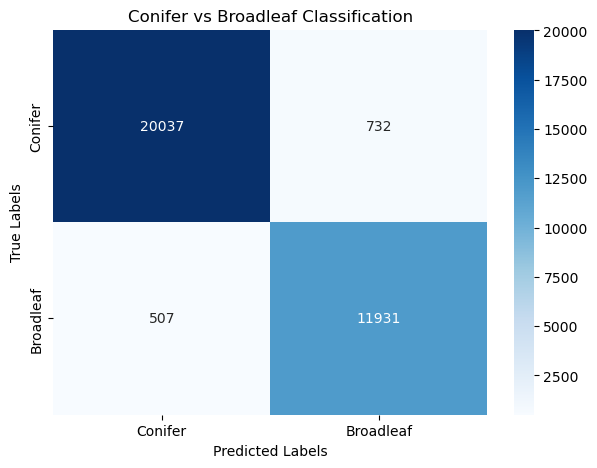

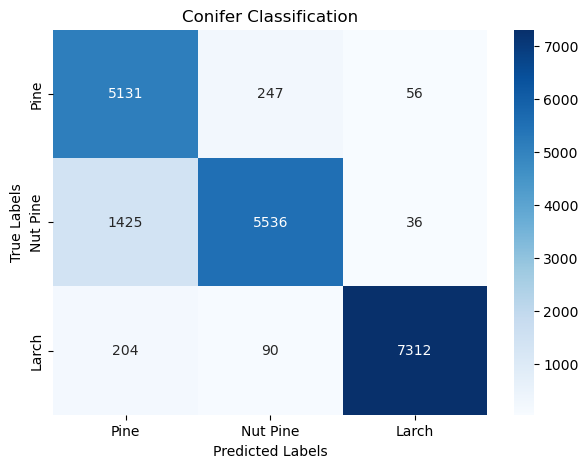

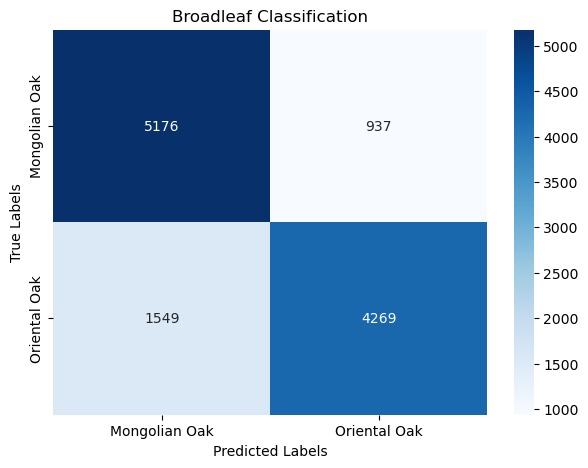

,precision,recall,f1-score,support,Category
Non-Forest,0.950955,0.969729,0.960250,3799.000000,Overall
Pine,0.716220,0.867602,0.784677,5914.000000,Overall
Nut Pine,0.931830,0.771245,0.843967,7178.000000,Overall
Larch,0.973506,0.932059,0.952331,7845.000000,Overall
Mongolian Oak,0.724930,0.820025,0.769551,6312.000000,Overall
Oriental Oak,0.766978,0.694372,0.728871,6148.000000,Overall
accuracy,0.836326,0.836326,0.836326,0.836326,Overall
macro avg,0.844070,0.842505,0.839941,37196.000000,Overall
weighted avg,0.845934,0.836326,0.837620,37196.000000,Overall
Conifer,0.975321,0.964755,0.970009,20769.000000,Conifer vs Broadleaf


In [8]:
model = ResNetLike_60_3(num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_60_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## Sentinel_2 데이터도 추가하여 사용

In [5]:
train_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/with_ndvi_s2',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/with_ndvi_s2',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
model = ResNetLike_120_3(num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_120_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:07<00:00, 146.63it/s]



Epoch [1/100], Train Loss: 0.5701, Train Accuracy: 77.87%, Val Loss: 2.7908, Val Accuracy: 46.03%



Epoch 2/100 - Training:  39%|███▊      | 1421/3683 [00:27<00:41, 54.53it/s]

: 

: 

## NDVI 없이 Planet + Sentinel_2 데이터 사용

In [ ]:
train_dataset = TiffDataset(
    large_tif_dir ='/home/elicer/forest_carbon_ai/data/source_data/with_s2',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = '/home/elicer/forest_carbon_ai/data/source_data/with_s2',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:10<00:00, 112.64it/s]



Epoch [1/1], Train Loss: 0.5121, Train Accuracy: 80.35%, Val Loss: 0.6505, Val Accuracy: 76.60%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:42<00:00, 86.31it/s]


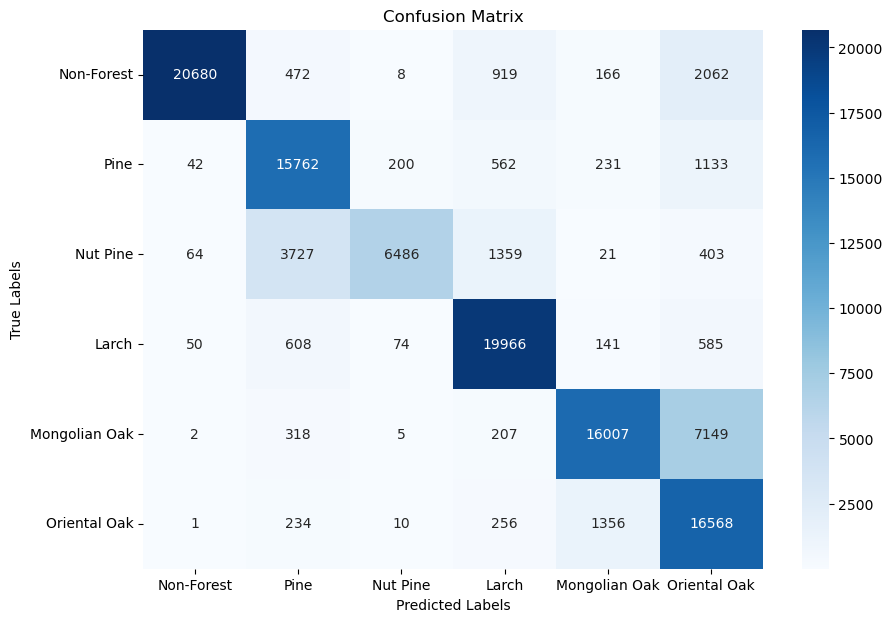

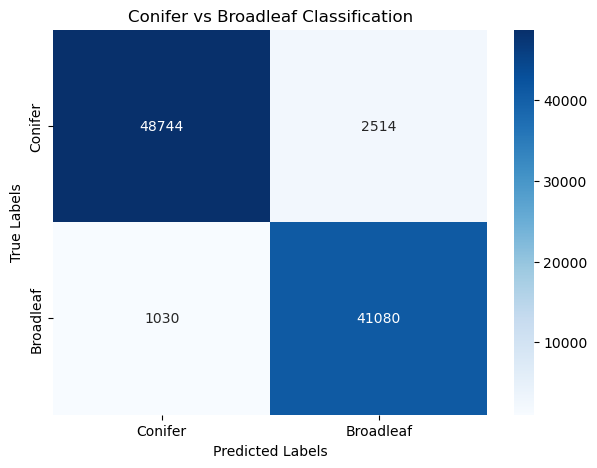

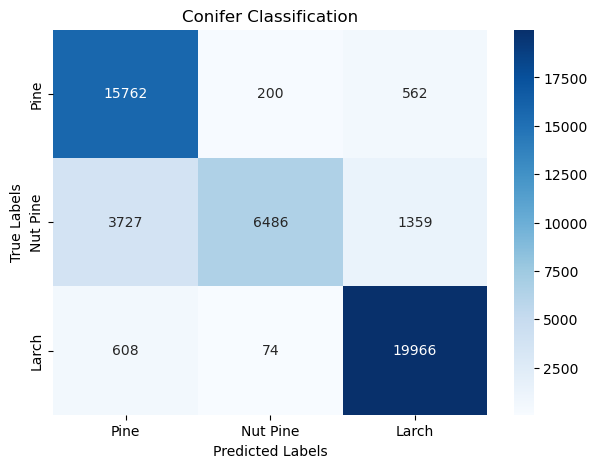

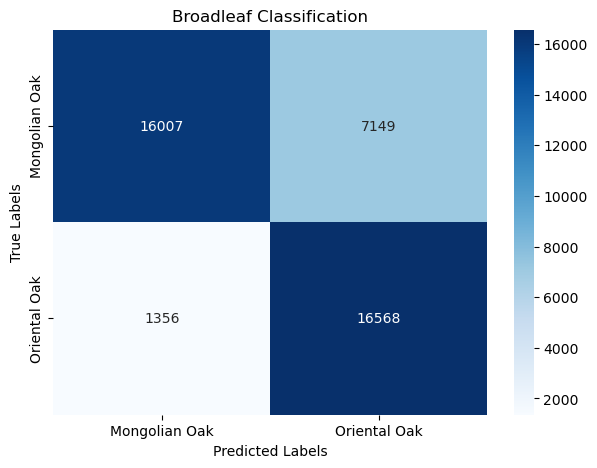


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:13<00:00, 85.37it/s]


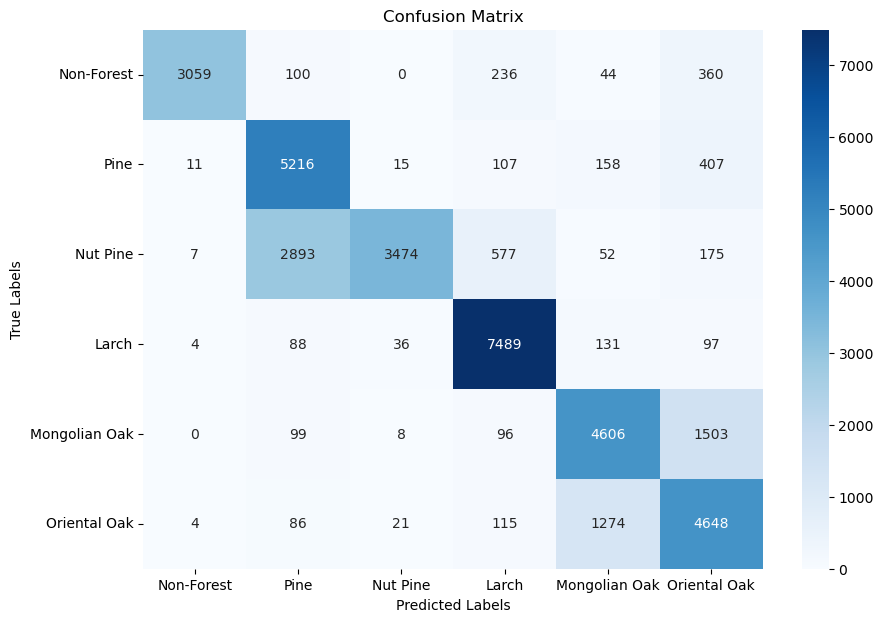

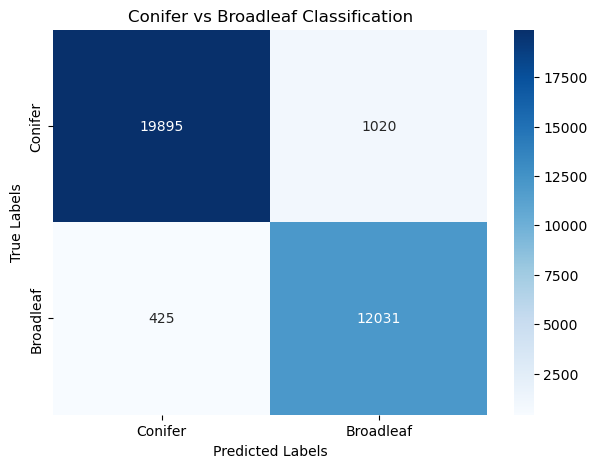

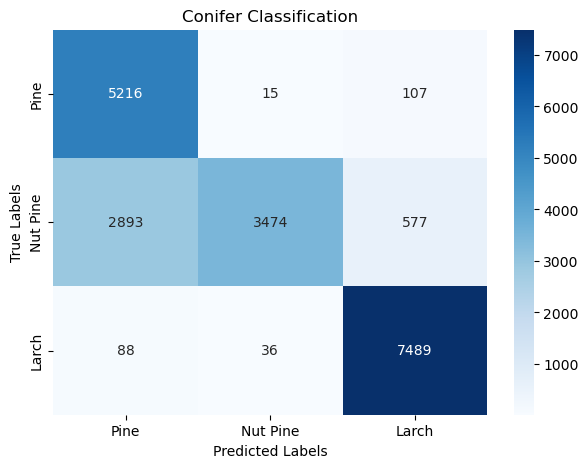

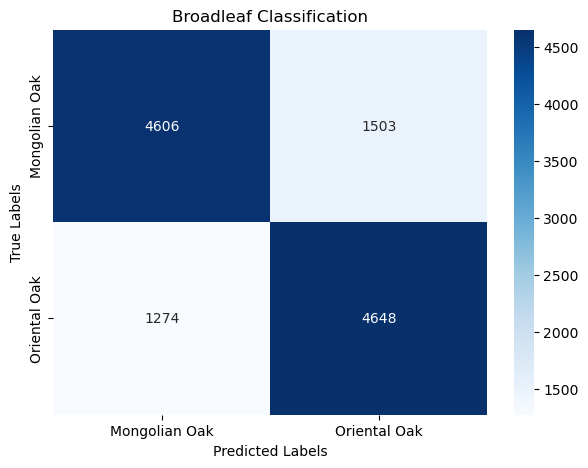

,precision,recall,f1-score,support,Category
Non-Forest,0.991572,0.805212,0.888727,3799.000000,Overall
Pine,0.614949,0.881975,0.724646,5914.000000,Overall
Nut Pine,0.977490,0.483979,0.647410,7178.000000,Overall
Larch,0.868794,0.954621,0.909687,7845.000000,Overall
Mongolian Oak,0.735196,0.729721,0.732448,6312.000000,Overall
Oriental Oak,0.646453,0.756018,0.696956,6148.000000,Overall
accuracy,0.765996,0.765996,0.765996,0.765996,Overall
macro avg,0.805742,0.768588,0.766646,37196.000000,Overall
weighted avg,0.802529,0.765996,0.762274,37196.000000,Overall
Conifer,0.979085,0.951231,0.964957,20915.000000,Conifer vs Broadleaf


: 

In [ ]:
model = ResNetLike_108_3(num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_108_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)